In [1]:
import os, torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from scipy.signal import find_peaks
import numpy as np, matplotlib.pyplot as plt, pandas as pd

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"using: {device} ")

using: mps 


In [3]:
df100 = pd.read_csv('data/100.csv')
df100.columns = ['samp_num', 'MLII', 'V5']

In [4]:
df100.head()

,samp_num,MLII,V5
0,0,995,1011
1,1,995,1011
2,2,995,1011
3,3,995,1011
4,4,995,1011


In [5]:
def detect_r_peaks(ecg_signal, sampling_rate):
    # Derivative to highlight the QRS complex
    diff_signal = np.diff(ecg_signal)

    # Squaring to make all data points positive and emphasize larger differences
    squared_signal = diff_signal ** 2

    # Moving window integration
    window_size = int(0.12 * sampling_rate)  # 120 ms window
    integrated_signal = np.convolve(squared_signal, np.ones(window_size)/window_size, mode='same')

    # Find peaks
    peaks, _ = find_peaks(integrated_signal, distance=sampling_rate/2.5)  
    # assuming at least 0.4 seconds between heartbeats
    
    return peaks

In [26]:
def detect_r_peaks2(ecg_signal, sampling_rate, threshold_factor=0.9):
    # Find local maxima
    window_size = int(0.12 * sampling_rate)  # 120 ms window, typical for adult human heart rate
    peaks = []

    for i in range(window_size, len(ecg_signal) - window_size):
        window = ecg_signal[i - window_size:i + window_size]
        if ecg_signal[i] == max(window):
            peaks.append(i)

    # Thresholding peaks
    threshold = threshold_factor * max(ecg_signal)
    r_peaks = np.array([peak for peak in peaks if ecg_signal[peak] > threshold])

    return r_peaks

In [27]:
# Load the data
# Replace 'your_data.csv' with the path to your dataset file
df = pd.read_csv('data/100.csv')
df.columns = ['samp_num', 'MLII', 'V5']

# Extract the MLII data
mlii_signal = df['MLII'].values

# Define the sampling rate
# You should replace this with the actual sampling rate of your data
sampling_rate = 360  # Example: 360 Hz

# Detect R-peaks
r_peaks1 = detect_r_peaks(mlii_signal, sampling_rate)
r_peaks2 = detect_r_peaks2(mlii_signal, sampling_rate)

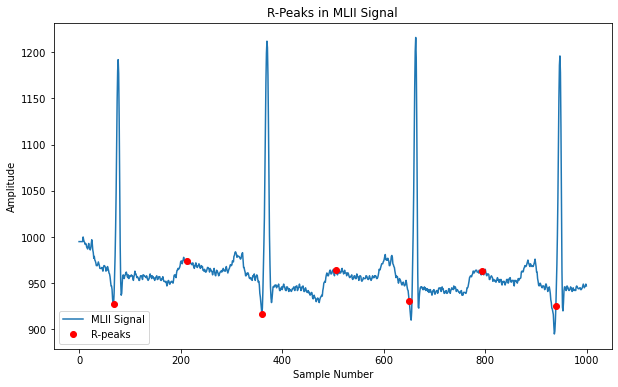

In [28]:
# Slicing the DataFrame to include only the first 500 samples
df_x = df.iloc[:1000]

# Filtering R-peaks to include only those within the first 500 samples
r_peaks_x = r_peaks1[r_peaks1 < 1000]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_x['samp_num'], df_x['MLII'], label='MLII Signal')
plt.plot(df_x['samp_num'][r_peaks_x], df_x['MLII'][r_peaks_x], 'ro', label='R-peaks')
plt.title('R-Peaks in MLII Signal')
plt.xlabel('Sample Number')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

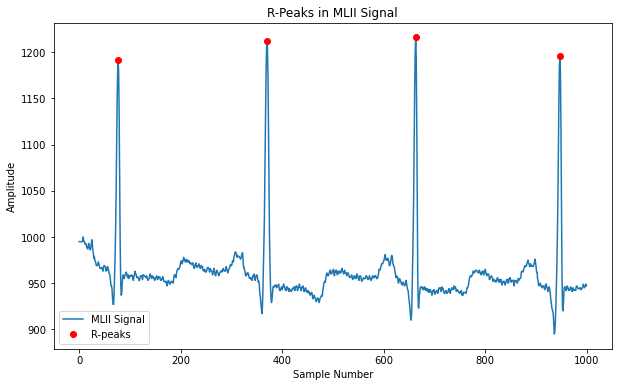

In [29]:
# Slicing the DataFrame to include only the first 1000 samples
df_x = df.iloc[:1000]

# Filtering R-peaks to include only those within the first 1000 samples
r_peaks_x = [peak for peak in r_peaks2 if peak < 1000]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_x['samp_num'], df_x['MLII'], label='MLII Signal')

# Ensuring that the indices for R-peaks are within the range of the sliced DataFrame
valid_r_peaks_x = df_x['samp_num'].iloc[r_peaks_x]
plt.plot(valid_r_peaks_x, df_x['MLII'].iloc[r_peaks_x], 'ro', label='R-peaks')

plt.title('R-Peaks in MLII Signal')
plt.xlabel('Sample Number')
plt.ylabel('Amplitude')
plt.legend()
plt.show()